# Comparing Clustering Methods for Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
import plotly.express as px
import plotly.graph_objects as go

## Data Preparation

In [2]:
# Load and prepare data
df = pd.read_csv('equipment_data.csv')

# Store true labels and drop them
true_labels = df['anomaly'].copy()

# Handle categorical data
# One-hot encode the equipment type (the important categorical feature)
equipment_dummies = pd.get_dummies(df['equipment'], prefix='equipment')
df = pd.concat([df, equipment_dummies], axis=1)

# Drop the original categorical columns
df = df.drop(['anomaly', 'equipment', 'manufacturer', 'location'], axis=1)

# Scale the numerical features
numerical_cols = ['temperature', 'pressure', 'vibration', 'humidity', 'noise']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Final dataset with scaled numerical features and one-hot encoded equipment
X_scaled = df.copy()

## DBSCAN Clustering

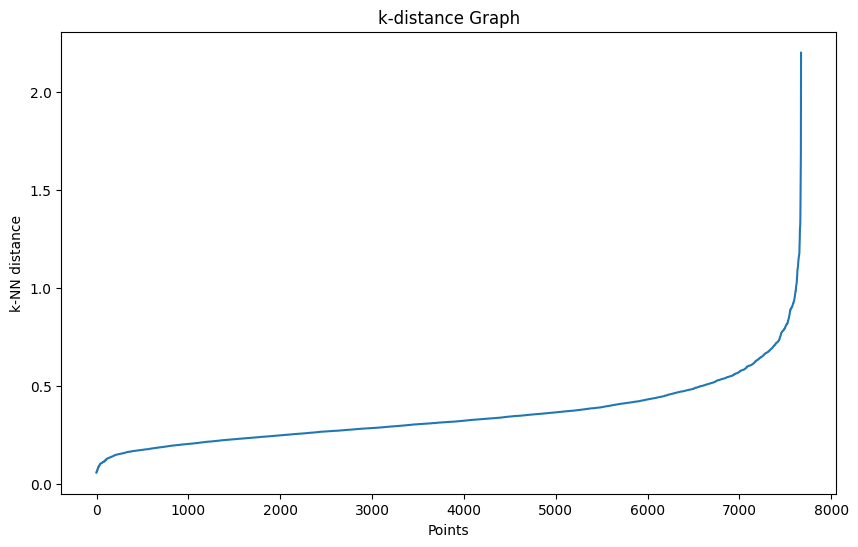

In [3]:
# Find optimal eps using k-nearest neighbors
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=2)
nbrs = neighbors.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Plot k-distance graph
distances = np.sort(distances, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances[:, 1])
plt.xlabel('Points')
plt.ylabel('k-NN distance')
plt.title('k-distance Graph')
plt.show()

# Fit DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Adjust parameters based on k-distance graph
dbscan_labels = dbscan.fit_predict(X_scaled)

# DBSCAN anomaly detection (points labeled as -1 are considered anomalies)
dbscan_anomalies = (dbscan_labels == -1).astype(int)

## Model Comparison

In [4]:
# Function to print evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Evaluate model
evaluate_model(true_labels, dbscan_anomalies, "DBSCAN")



DBSCAN Results:

Confusion Matrix:
[[ 573 6332]
 [   3  764]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.08      0.15      6905
         1.0       0.11      1.00      0.19       767

    accuracy                           0.17      7672
   macro avg       0.55      0.54      0.17      7672
weighted avg       0.91      0.17      0.16      7672



## Visualization of Results

In [5]:
# Create interactive 3D scatter plots for each method
def plot_3d_results(X, labels, predictions, title):
    fig = go.Figure()
    
    # Plot points
    colors = ['blue' if pred == 0 else 'red' for pred in predictions]
    markers = ['circle' if label == 0 else 'x' for label in labels]
    
    fig.add_trace(go.Scatter3d(
        x=X.iloc[:, 0],
        y=X.iloc[:, 1],
        z=X.iloc[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=colors,
            symbol=markers
        ),
        name='Points'
    ))
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=X.columns[0],
            yaxis_title=X.columns[1],
            zaxis_title=X.columns[2]
        )
    )
    
    fig.show()

# Plot results for each method
plot_3d_results(X_scaled, true_labels, kmeans_anomalies, "K-Means Results")
plot_3d_results(X_scaled, true_labels, dbscan_anomalies, "DBSCAN Results")
plot_3d_results(X_scaled, true_labels, gmm_anomalies, "GMM Results")

NameError: name 'kmeans_anomalies' is not defined

In [28]:
# Create a function to visualize misclassifications
def plot_misclassifications(X, true_labels, predictions, method_name):
    fig = go.Figure()
    
    # Convert boolean masks to indices
    true_positives = np.where(np.logical_and(true_labels == 1, predictions == 1))[0]
    false_negatives = np.where(np.logical_and(true_labels == 1, predictions == 0))[0]
    false_positives = np.where(np.logical_and(true_labels == 0, predictions == 1))[0]
    true_negatives = np.where(np.logical_and(true_labels == 0, predictions == 0))[0]
    
    # Add traces for each category
    fig.add_trace(go.Scatter3d(
        x=X.iloc[true_positives, 0],
        y=X.iloc[true_positives, 1],
        z=X.iloc[true_positives, 2],
        mode='markers',
        marker=dict(size=6, color='green'),
        name='True Positives (Correctly detected anomalies)'
    ))
    
    fig.add_trace(go.Scatter3d(
        x=X.iloc[false_negatives, 0],
        y=X.iloc[false_negatives, 1],
        z=X.iloc[false_negatives, 2],
        mode='markers',
        marker=dict(size=6, color='red'),
        name='False Negatives (Undetected anomalies)'
    ))
    
    fig.add_trace(go.Scatter3d(
        x=X.iloc[false_positives, 0],
        y=X.iloc[false_positives, 1],
        z=X.iloc[false_positives, 2],
        mode='markers',
        marker=dict(size=6, color='orange'),
        name='False Positives (False alarms)'
    ))
    
    fig.add_trace(go.Scatter3d(
        x=X.iloc[true_negatives, 0],
        y=X.iloc[true_negatives, 1],
        z=X.iloc[true_negatives, 2],
        mode='markers',
        marker=dict(size=4, color='blue', opacity=0.3),
        name='True Negatives (Correctly identified normal points)'
    ))
    
    fig.update_layout(
        title=f"Misclassification Analysis - {method_name}",
        scene=dict(
            xaxis_title=X.columns[0],
            yaxis_title=X.columns[1],
            zaxis_title=X.columns[2]
        ),
        legend=dict(
            x=0,
            y=0.9
        )
    )
    
    fig.show()

# Plot misclassifications for each method
plot_misclassifications(X_scaled, true_labels, kmeans_anomalies, "K-Means")
plot_misclassifications(X_scaled, true_labels, dbscan_anomalies, "DBSCAN")
plot_misclassifications(X_scaled, true_labels, gmm_anomalies, "GMM")

# Calculate and display misclassification statistics
def print_misclassification_stats(true_labels, predictions, method_name):
    true_positives = np.sum(np.logical_and(true_labels == 1, predictions == 1))
    false_negatives = np.sum(np.logical_and(true_labels == 1, predictions == 0))
    false_positives = np.sum(np.logical_and(true_labels == 0, predictions == 1))
    true_negatives = np.sum(np.logical_and(true_labels == 0, predictions == 0))
    
    total_anomalies = np.sum(true_labels == 1)
    total_normal = np.sum(true_labels == 0)
    
    print(f"\n{method_name} Misclassification Statistics:")
    print(f"Undetected Anomalies (False Negatives): {false_negatives} out of {total_anomalies} true anomalies ({false_negatives/total_anomalies*100:.2f}%)")
    print(f"False Alarms (False Positives): {false_positives} out of {total_normal} normal points ({false_positives/total_normal*100:.2f}%)")
    print(f"Correctly Detected Anomalies (True Positives): {true_positives} out of {total_anomalies} true anomalies ({true_positives/total_anomalies*100:.2f}%)")

# Print statistics for each method
print_misclassification_stats(true_labels, kmeans_anomalies, "K-Means")
print_misclassification_stats(true_labels, dbscan_anomalies, "DBSCAN")
print_misclassification_stats(true_labels, gmm_anomalies, "GMM")



K-Means Misclassification Statistics:
Undetected Anomalies (False Negatives): 512 out of 767 true anomalies (66.75%)
False Alarms (False Positives): 129 out of 6905 normal points (1.87%)
Correctly Detected Anomalies (True Positives): 255 out of 767 true anomalies (33.25%)

DBSCAN Misclassification Statistics:
Undetected Anomalies (False Negatives): 3 out of 767 true anomalies (0.39%)
False Alarms (False Positives): 6332 out of 6905 normal points (91.70%)
Correctly Detected Anomalies (True Positives): 764 out of 767 true anomalies (99.61%)

GMM Misclassification Statistics:
Undetected Anomalies (False Negatives): 438 out of 767 true anomalies (57.11%)
False Alarms (False Positives): 55 out of 6905 normal points (0.80%)
Correctly Detected Anomalies (True Positives): 329 out of 767 true anomalies (42.89%)
